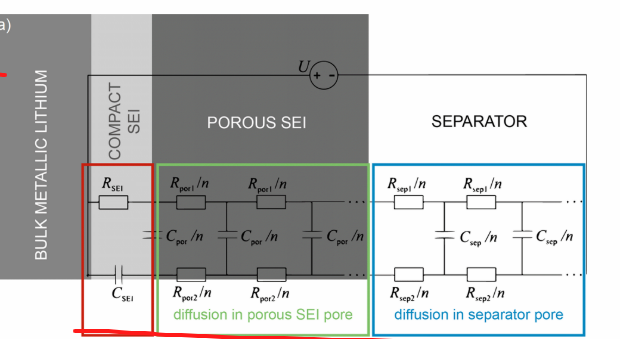 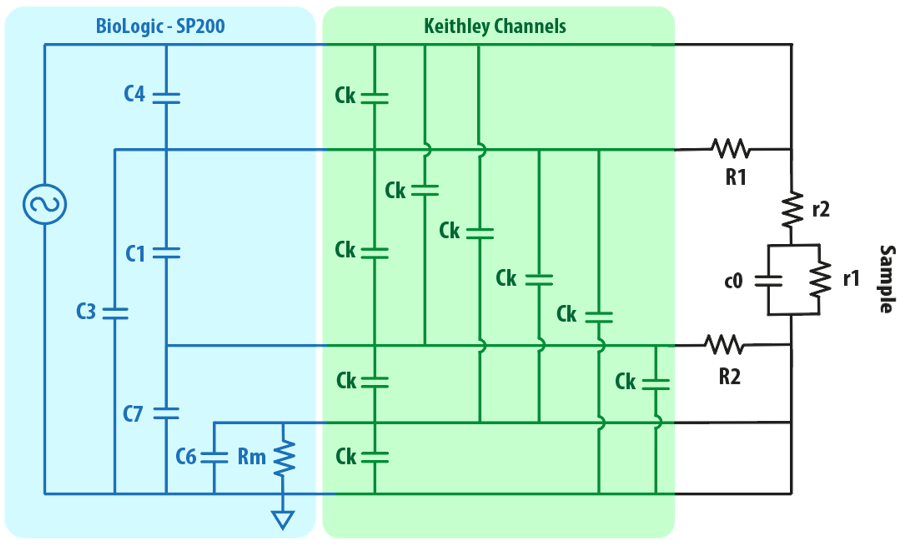

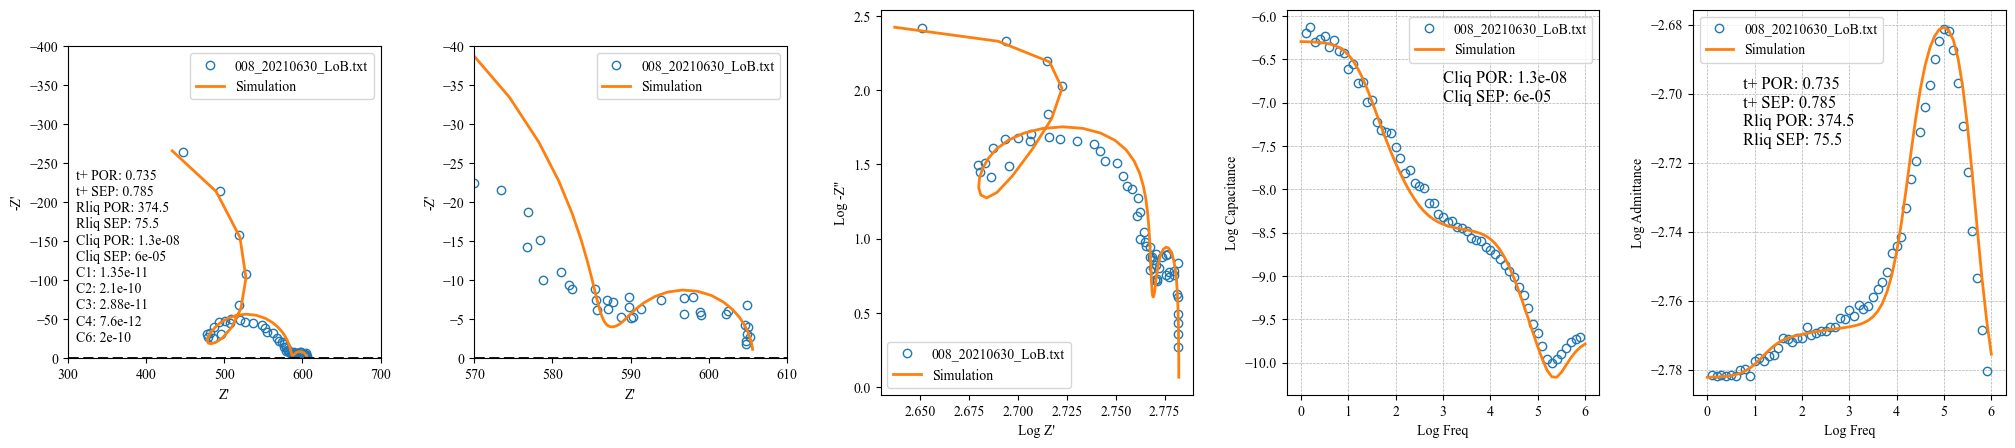

In [52]:
from sympy.interactive import printing
printing.init_printing(use_latex =True)
from sympy import *
import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
#_____________________________________________________________________________________________________________________________________________
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams['lines.linewidth'] = 2
#from numpy.linalg import svd
#from scipy.optimize import leastsq, least_squares, minimize, differential_evolution
#from lmfit import Model
#import glob, os
#import random, time
#from pprint import pprint
#from collections import OrderedDict

from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

#Define the number of slice n=??
n = 400
datafile_path = "008_20210630_Lowerbody+stray_sim,n=200_ver2.txt"

data_file = '008_20210630_LoB.txt'
root_path = r'D:\OneDrive\Tran Tran Workstation\Bodyimpedance\DATA (3rd year)\BioLogic data\All data'
data_path = os.path.join(root_path, data_file)  # Use os.path.join to concatenate paths
results_folder = r'D:\OneDrive\Tran Tran Workstation\Bodyimpedance\DATA (3rd year)\BioLogic data\Fit result'
#Function to read data, use for text file and mtp file.
    
def read_data(path, freq_lower_bound, freq_upper_bound):
    df = pd.read_csv(path, header=None, sep='\t')
    df = df.reset_index()
    F0 = df.iloc[:, 1]
    Z0 = df.iloc[:, 2] + 1j*df.iloc[:, 3]
    
     # Limiting the frequency range
    mask = (F0 >= freq_lower_bound) & (F0 <= freq_upper_bound)
    df = df[mask]
    F = F0[mask]
    Z = Z0[mask]
    
    return df.index, F, Z

# Define your frequency boundaries here
freq_lower_bound = 0.1  # Example lower bound
freq_upper_bound = 10**6 # Example upper bound

index, F, Z = read_data(data_path, freq_lower_bound, freq_upper_bound)
for i, f, z in zip(index, F, Z):
    #print("{:02d} {:10.5e} {:10.5e} {:10.5e}".format(i, f, np.real(z), np.imag(z)))
    if i==59:
        R_segment = np.real(z)

freq_exp=0 #frequency [Hz] exponent
Re=[]
Im=[]
freq=[]

#Parameters
# t- in body impedance, representative value for arms and legs representative value for trunks. Low frequency response.
#Body impedance
tplus_POR=0.735           
tplus_SEP=0.785            
Rliq_POR = 374.5
Rliq_SEP = 75.5
C_POR = 1.3e-8
apor = 1
C_SEP = 0.6e-4
asep = 1
#stray effect
C1 = 13.5e-12
C2 = 2.1e-10
C3 = 28.8e-12
C4 = 7.6e-12
C6 = 200e-12
C7 = C2 - C6
R1 = 1
R2 = R1
Ck = 1/(9.05e6*R_segment + 0.55e10)

#Rp2 = 2 #Rpor2
#Rs1 = 18 #Rsep1
#Rs2 = 2.5 #Rsep1
Rsei = 0
Qsei = 1e-15 #Q_SEI
asei = 1 #alpha SEI



while freq_exp<6:
    f = 10 ** freq_exp
    w = 2 * np.pi * f
    iw = 1j * 2 * np.pi * f
    #w=2*np.pi*10**freq_exp
    ZC1 = 1/(iw*C1)
    ZC3 = 1/(iw*C3)
    ZC7 = 1/(iw*C7)
    ZRmC6 = 1000/(1+iw*1000*C6)
    ZR1C4 = R1/(1+iw*R1*C4)
    ZR2 = R2
    ZCk = 1/(iw*Ck)
    ZA = Rsei #R_SEI part
    ZB = 1/(iw**asei*Qsei) #C_SEI part
    Z_Cp = 1/(iw**apor*C_POR) #C_por
    Z_Cs = 1/(iw**asep*C_SEP) #C_sep
    Rp1=Rliq_POR/tplus_POR
    Rp2=Rliq_POR/(1-tplus_POR)
    Rs1=Rliq_SEP/tplus_SEP
    Rs2=Rliq_SEP/(1-tplus_SEP)
    
    #Matrices construction
    #Matrix A1
    a1 = np.eye(n+3, n+3, k=-1, dtype=np.complex128) * (-n*Z_Cp) #need to change dtype to np.complex128 when working in matrix solving
    a1 += np.eye(n+3, n+3, k=0, dtype=np.complex128) * (Rp1/n + 2*n*Z_Cp + Rp2/n)
    a1 += np.eye(n+3, n+3, k=+1, dtype=np.complex128) * (-n*Z_Cp)
    a1[0,0] = ZA + Rp1 + Rs1
    a1[1,1] = ZA + n*Z_Cp + ZB
    #a1[size-1, size-1] = Rs1/n + n*Z_Cs + Rs2/n
    a1[0,1] = -ZA
    a1[1,0] = -ZA
    a1[0,2:n+2] = -Rp1/n
    a1[2:n+2,0] = -Rp1/n
    a1[0,n+2:2*n+2] = -Rs1/n
    a1[n+2:2*n+2,0] = -Rs1/n
    a1[n+2,n+2] = Rs1/n + n*Z_Cp + n*Z_Cs + Rs2/n
    #MAtrix A2
    a2=np.zeros(shape=(n+3,n-1),dtype=np.complex128)
    a2[0,0:n+2]=-Rs1/n
    a2[n+2,0]=-n*Z_Cs
    #MAtrix B1
    b1=np.transpose(a2)
    #MAtrix B2
    b2 = np.eye(n-1, n-1, k=-1, dtype=np.complex128) * (-n*Z_Cs) #need to change dtype to np.complex when working in matrix solving
    b2 += np.eye(n-1, n-1, k=0, dtype=np.complex128) * (Rs1/n + 2*n*Z_Cs + Rs2/n)
    b2 += np.eye(n-1, n-1, k=+1, dtype=np.complex128) * (-n*Z_Cs)
    b2[n-2,n-2]=Rs1/n+n*Z_Cs+Rs2/n
    
    #Final big matrix
    FIRST=np.concatenate((a1,a2), 1)
    SECOND=np.concatenate((b1,b2), 1)
    final_matrix=np.concatenate((FIRST,SECOND), 0)
    
    bb=np.zeros(2*n+2,dtype=np.complex128)
    bb[0]=1+1j
    x=np.linalg.solve(final_matrix,bb)
    Z1=(1+1j)/(x[0])
    Z0=(ZC1*ZCk*(Z1*ZC3*ZC7*ZCk**2 + Z1*ZC3*ZCk**2*ZR2 + Z1*ZC3*ZCk**2*ZRmC6 + ZC3*ZCk**2*ZR2*ZRmC6 - ZC7*ZCk**2*ZR1C4*ZRmC6 + 2*Z1*ZC3*ZC7*ZCk*ZR2 + Z1*ZC3*ZC7*ZCk*ZR1C4 + 2*Z1*ZC3*ZC7*ZCk*ZRmC6 + Z1*ZC3*ZCk*ZR2*ZR1C4 - Z1*ZC7*ZCk*ZR2*ZR1C4 + 5*Z1*ZC3*ZC7*ZR2*ZRmC6 + 4*Z1*ZC3*ZCk*ZR2*ZRmC6 + Z1*ZC3*ZCk*ZR1C4*ZRmC6 - 2*Z1*ZC7*ZCk*ZR1C4*ZRmC6 + 5*Z1*ZC3*ZR2*ZR1C4*ZRmC6 - 5*Z1*ZC7*ZR2*ZR1C4*ZRmC6 + ZC3*ZC7*ZCk*ZR2*ZRmC6 - ZC3*ZC7*ZCk*ZR1C4*ZRmC6 + 2*ZC3*ZCk*ZR2*ZR1C4*ZRmC6 - 2*ZC7*ZCk*ZR2*ZR1C4*ZRmC6))/(Z1*ZC3*ZC7*ZCk**3 + ZC1*ZC3*ZC7*ZCk**3 + ZC1*ZC3*ZCk**3*ZR2 + ZC3*ZC7*ZCk**3*ZR2 + ZC1*ZC7*ZCk**3*ZR1C4 + ZC3*ZC7*ZCk**3*ZR1C4 + ZC1*ZCk**3*ZR2*ZR1C4 + ZC3*ZCk**3*ZR2*ZR1C4 + ZC7*ZCk**3*ZR2*ZR1C4 + 4*Z1*ZC1*ZC3*ZC7*ZCk**2 + 2*Z1*ZC1*ZC3*ZCk**2*ZR2 + 3*Z1*ZC3*ZC7*ZCk**2*ZR2 + 2*Z1*ZC1*ZC7*ZCk**2*ZR1C4 + 3*Z1*ZC3*ZC7*ZCk**2*ZR1C4 + Z1*ZC1*ZCk**2*ZR2*ZR1C4 + Z1*ZC3*ZCk**2*ZR2*ZR1C4 + Z1*ZC7*ZCk**2*ZR2*ZR1C4 + 4*ZC1*ZC3*ZC7*ZCk**2*ZR2 + 4*ZC1*ZC3*ZC7*ZCk**2*ZR1C4 + 4*ZC1*ZC3*ZCk**2*ZR2*ZR1C4 + 4*ZC1*ZC7*ZCk**2*ZR2*ZR1C4 + 6*ZC3*ZC7*ZCk**2*ZR2*ZR1C4 + 10*Z1*ZC1*ZC3*ZC7*ZCk*ZR2 + 10*Z1*ZC1*ZC3*ZC7*ZCk*ZR1C4 + 25*Z1*ZC1*ZC3*ZC7*ZR2*ZR1C4 + 5*Z1*ZC1*ZC3*ZCk*ZR2*ZR1C4 + 5*Z1*ZC1*ZC7*ZCk*ZR2*ZR1C4 + 10*Z1*ZC3*ZC7*ZCk*ZR2*ZR1C4 + 15*ZC1*ZC3*ZC7*ZCk*ZR2*ZR1C4)
    #print(10**freq_exp,Z0.real,Z0.imag)
    Re.append(Z0.real)
    Im.append(Z0.imag)
    freq.append(10**freq_exp)
    freq_exp+=0.1

#plt.plot(Re, Im, '+')

# Use plt.gca() to get the current axes and set the aspect ratio on that axes.
#plt.gca().set_aspect('equal')

#plt.show()

#Exporting data
data = np.array([freq, Re, Im])
data = data.T

with open(datafile_path, 'w+') as datafile_id:
    np.savetxt(datafile_id, data)
    

#print("Number of data : {:3}".format(len(index)))
#print("No.Frequency   Z'          Z'' ")
Cap_sim = - np.divide(Im, (np.square(Im) + np.square(Re))*2*np.pi*freq)
Cap_raw = -np.divide(np.real(Z),(np.square(np.real(Z)) + np.square(np.imag(Z)))*2*np.pi*F)
#for i, f, z in zip(index, F, Z):
    #print("{:02d} {:10.5e} {:10.5e} {:10.5e}".format(i, f, np.real(z), np.imag(z)))
fig, (ax1,ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(25, 5))
#ax1 = fig.add_subplot(111)
ax1.plot(np.real(Z), np.imag(Z), 'o', label=data_file, markerfacecolor='none')
ax1.plot(Re, Im, label='Simulation')
ax1.set_aspect('equal', adjustable='box')
ax1.legend(loc='best', fontsize=10)
notation_text1 = (f"t+ POR: {tplus_POR}\n"
                 f"t+ SEP: {tplus_SEP}\n"
                 f"Rliq POR: {Rliq_POR}\n"
                 f"Rliq SEP: {Rliq_SEP}\n"
                 f"Cliq POR: {C_POR}\n"
                 f"Cliq SEP: {C_SEP}\n"
                 f"C1: {C1}\n"
                 f"C2: {C2}\n"
                 f"C3: {C3}\n"
                 f"C4: {C4}\n"
                 f"C6: {C6}\n")
ax1.text(310, -1, notation_text1, fontsize=10, color='black', ha='left')
# set x and y limits to be the same
x0, x1 = ax1.get_xlim()
y0, y1 = ax1.get_ylim()
ax1.set_xlim([300, 700])
ax1.set_ylim([-400, 0])
#ax1.set_aspect('equal', adjustable='datalim')
ax1.invert_yaxis()
ax1.set_xlabel("Z'")
ax1.set_ylabel("-Z'")
# Add a zero line
ax1.axvline(x=0, color='black', linestyle='--')
ax1.axhline(y=0, color='black', linestyle='--')


ax2.plot(np.real(Z), np.imag(Z), 'o', label=data_file, markerfacecolor='none')
ax2.plot(Re, Im, label='Simulation')
ax2.set_aspect('equal', adjustable='box')
ax2.legend(loc='best', fontsize=10)
ax2.set_xlim([570, 610])
ax2.set_ylim([-40, 0])
ax2.invert_yaxis()
ax2.set_xlabel("Z'")
ax2.set_ylabel("-Z'")
# Add a zero line
ax2.axvline(x=0, color='black', linestyle='--')
ax2.axhline(y=0, color='black', linestyle='--')


ax3.plot(np.log10(np.abs(np.real(Z))), np.log10(np.abs(np.imag(Z))), 'o', label=data_file, markerfacecolor='none')
ax3.plot(np.log10(np.abs(Re)), np.log10(np.abs(Im)), label='Simulation')
ax3.legend(loc='best', fontsize=10)
ax3.set_xlabel("Log Z'")
ax3.set_ylabel("Log -Z''")

ax4.plot(np.log10(F), np.log10(np.abs(np.real(1/(1j * 2 * np.pi * F*Z)))), 'o', label=data_file, markerfacecolor='none')
ax4.plot(np.log10(freq), np.log10(Cap_sim), label='Simulation')
ax4.legend(loc='best', fontsize=10)
ax4.set_xlabel('Log Freq')
ax4.set_ylabel('Log Capacitance')
ax4.grid(True, which="both", ls="--", linewidth=0.5)
notation_text2 = (f"Cliq POR: {C_POR}\n"
                 f"Cliq SEP: {C_SEP}\n")
ax4.text(3, -7.2, notation_text2, fontsize=12, color='black', ha='left')

ax5.plot(np.log10(F), np.log10(np.abs(np.real(Z)/(np.real(Z)**2+np.imag(Z)**2))), 'o', label=data_file, markerfacecolor='none')
ax5.plot(np.log10(freq), np.log10(np.abs(Re/(np.square(Re)+np.square(Im)))), label='Simulation')
ax5.legend(loc='best', fontsize=10)
ax5.set_xlabel('Log Freq')
ax5.set_ylabel('Log Admittance')
ax5.grid(True, which="both", ls="--", linewidth=0.5)
notation_text3 = (f"t+ POR: {tplus_POR}\n"
                 f"t+ SEP: {tplus_SEP}\n"
                 f"Rliq POR: {Rliq_POR}\n"
                 f"Rliq SEP: {Rliq_SEP}\n")
ax5.text(0.75, -2.72, notation_text3, fontsize=12, color='black', ha='left')

plt.subplots_adjust(wspace=0.3)
plt.show()